# Archive of Our Own x NetworkX

Link to data: https://archiveofourown.org/admin_posts/18804

Questions for now
* do the spikes in fics published on particular dates correspond with major releases e.g. avengers 2012?
* can i make a networkx social network of all the characters and relationships?
* clean up graphs - some non resolved dupes in tags
* scatter plot of average fic length for various ships/fandoms

In [262]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import scipy
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, from_networkx, output_file, save
from bokeh.models import HoverTool, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.layouts import column
import matplotlib.colors as mcolors
from bokeh.embed import file_html
from bokeh.resources import CDN

np.random.seed(seed=42)

In [2]:
tags = pd.read_csv("tags-20210226.csv")
works = pd.read_csv("works-20210226.csv")

## Warm-Up

### Works

In [3]:
works.head()

,creation date,language,restricted,complete,word_count,tags,Unnamed: 6
0,2021-02-26,en,False,True,388.0,10+414093+1001939+4577144+1499536+110+4682892+...,NaN
1,2021-02-26,en,False,True,1638.0,10+20350917+34816907+23666027+23269305+2326930...,NaN
2,2021-02-26,en,False,True,1502.0,10+10613413+9780526+3763877+3741104+7657229+30...,NaN
3,2021-02-26,en,False,True,100.0,10+15322+54862755+20595867+32994286+663+471751...,NaN
4,2021-02-26,en,False,True,994.0,11+721553+54604+1439500+3938423+53483274+54862...,NaN


In [4]:
works["creation date"] = pd.to_datetime(works["creation date"])
works["creation date"]

0         2021-02-26
1         2021-02-26
2         2021-02-26
3         2021-02-26
4         2021-02-26
             ...    
7269688   2008-09-13
7269689   2008-09-13
7269690   2008-09-13
7269691   2008-09-13
7269692   2008-09-13
Name: creation date, Length: 7269693, dtype: datetime64[ns]

<Figure size 1200x600 with 0 Axes>

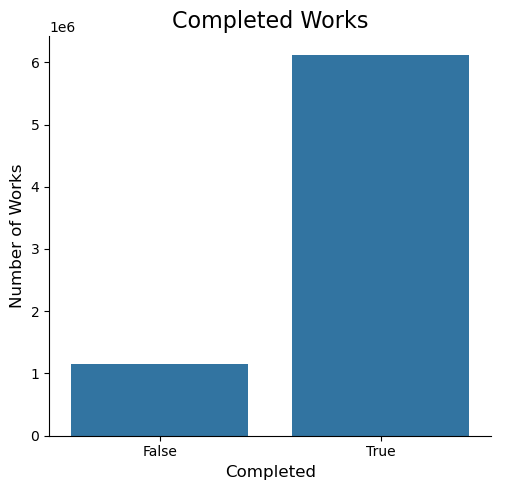

In [5]:
plt.figure(figsize=(12,6))
sns.catplot(data=works, x="complete", kind="count")
# Customize the plot
plt.title('Completed Works', fontsize=16)
plt.xlabel('Completed', fontsize=12)
plt.ylabel('Number of Works', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

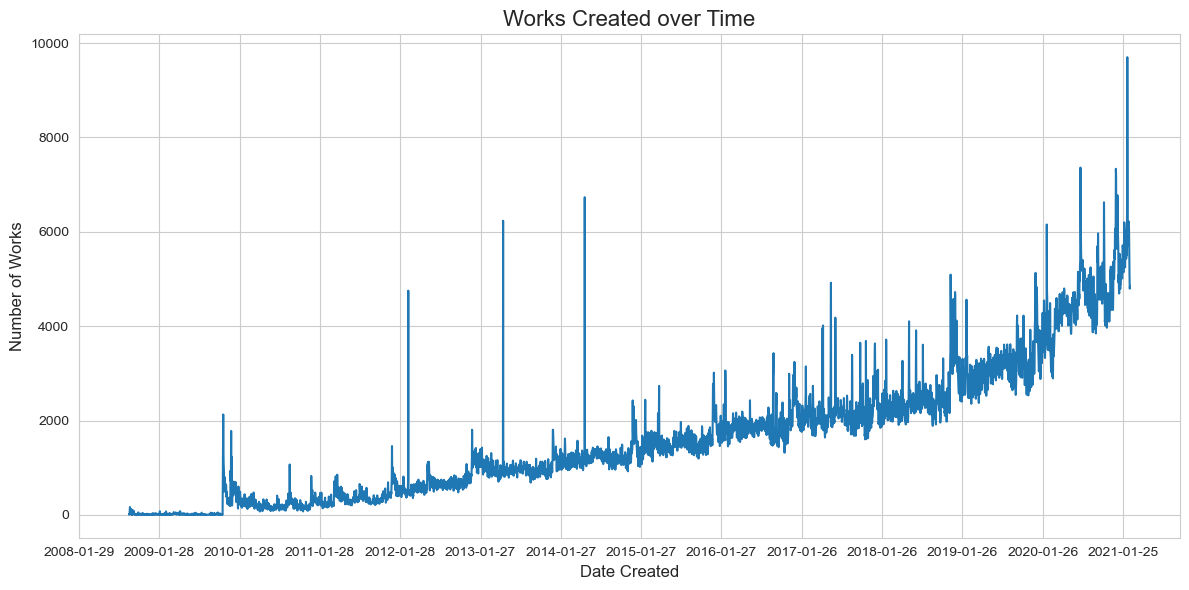

In [6]:
works_dates = works['creation date'].value_counts().sort_index().reset_index()
works_dates.columns = ['date', 'works']

sns.set_style("whitegrid")

plt.figure(figsize=(12,6))
ax = sns.lineplot(x="date", y="works", data=works_dates)

# Customize the plot
plt.title('Works Created over Time', fontsize=16)
plt.xlabel('Date Created', fontsize=12)
plt.ylabel('Number of Works', fontsize=12)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 365))

# Show the plot
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

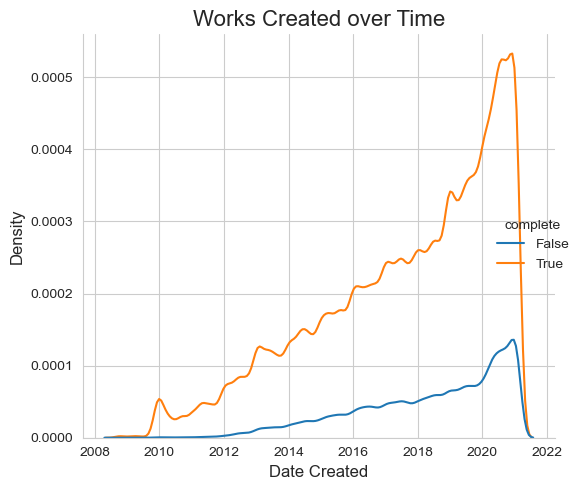

In [7]:
plt.figure(figsize=(12,6))

works = works.sort_values(by="creation date")
ax = sns.displot(data=works, x="creation date", hue="complete", kind="kde")

# Customize the plot
plt.title('Works Created over Time', fontsize=16)
plt.xlabel('Date Created', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
print(works['language'].value_counts().head(10))


language
en      6587693
zh       335179
ru       136724
es        70645
fr        32145
it        24261
id        16015
ptBR      15336
de        14426
pl        14261
Name: count, dtype: int64


#### Process tag column

In [9]:
works['tags'] = works['tags'].astype(str).apply(lambda tags: tags.split('+'))

### Tags

In [10]:
tags.head()

,id,type,name,canonical,cached_count,merger_id
0,1,Media,TV Shows,True,910,NaN
1,2,Media,Movies,True,1164,NaN
2,3,Media,Books & Literature,True,134,NaN
3,4,Media,Cartoons & Comics & Graphic Novels,True,166,NaN
4,5,Media,Anime & Manga,True,501,NaN


In [11]:
tags['type'].value_counts()

type
Freeform          9244331
Relationship      2048295
Character         1509000
UnsortedTag       1460615
Fandom             204858
Category               15
Media                  12
Rating                  6
ArchiveWarning          6
Name: count, dtype: int64

In [12]:
# split up tags so easier

relationships = tags[tags['type'] == "Relationship"]
freeform_tags = tags[tags['type'] == "Freeform"]
characters = tags[tags['type'] == "Character"]
unsorted_tags = tags[tags['type'] == "UnsortedTag"]
fandoms = tags[tags['type'] == "Fandom"]
categories = tags[tags['type'] == "Category"]
media = tags[tags['type'] == "Media"]
ratings = tags[tags['type'] == "Rating"]
archive_warnings = tags[tags['type'] == "ArchiveWarning"]

Fandoms

In [13]:
fandoms = fandoms.sort_values(by="cached_count", ascending=False)
fandoms.head(20)

,id,type,name,canonical,cached_count,merger_id
94292,136512,Fandom,Harry Potter - J. K. Rowling,True,361919,NaN
25,27,Fandom,Supernatural,True,310300,NaN
230408,414093,Fandom,Marvel Cinematic Universe,True,240536,NaN
1553725,3828398,Fandom,僕のヒーローアカデミア | Boku no Hero Academia | My Hero ...,True,204096,NaN
680695,1002903,Fandom,방탄소년단 | Bangtan Boys | BTS,True,203097,NaN
168289,258526,Fandom,Teen Wolf (TV),True,172802,NaN
679946,1001939,Fandom,The Avengers (Marvel Movies),True,157813,NaN
92059,133185,Fandom,Sherlock (TV),True,151925,NaN
5974,7266,Fandom,Marvel,True,147757,NaN
494603,758208,Fandom,Haikyuu!!,True,130918,NaN


/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/2187897710.py:10: UserWarning: Glyph 20693 (\N{CJK UNIFIED IDEOGRAPH-50D5}) missing from current font.
  plt.tight_layout()
/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/2187897710.py:10: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/2187897710.py:10: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from current font.
  plt.tight_layout()
/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/2187897710.py:10: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/2187897710.py:10: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from current font.
  plt.tight_layout()
/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/21

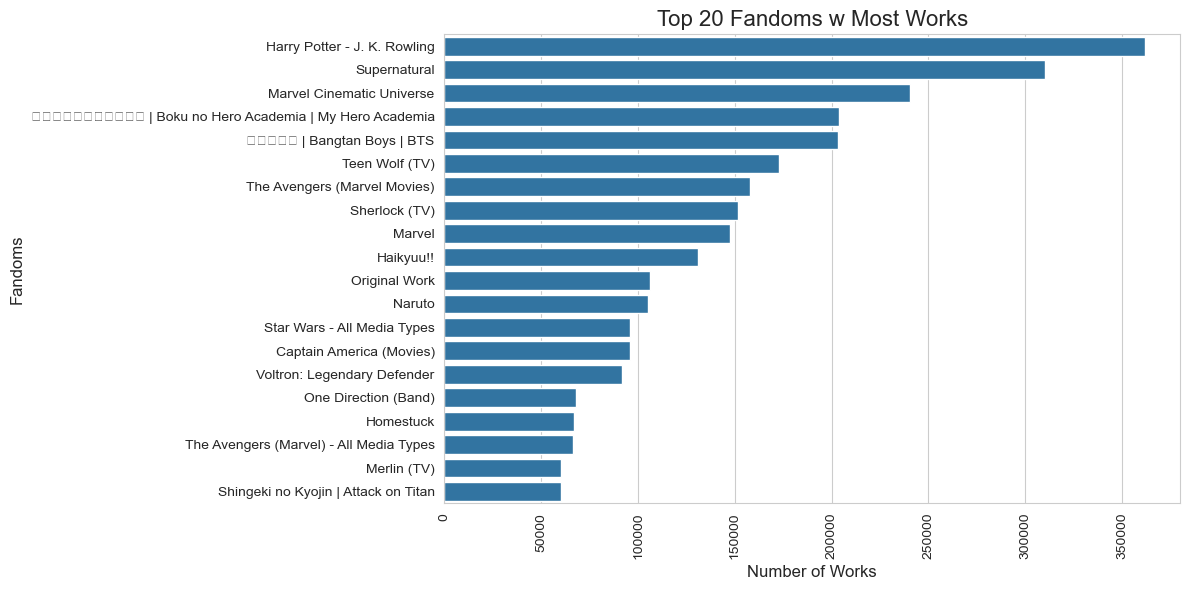

In [14]:
plt.figure(figsize=(12,6))
sns.barplot(data=fandoms.head(20), y="name", x="cached_count", orient = 'h')
# Customize the plot
plt.title('Top 20 Fandoms w Most Works', fontsize=16)
plt.xlabel('Number of Works', fontsize=12)
plt.ylabel('Fandoms', fontsize=12)
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

Categories

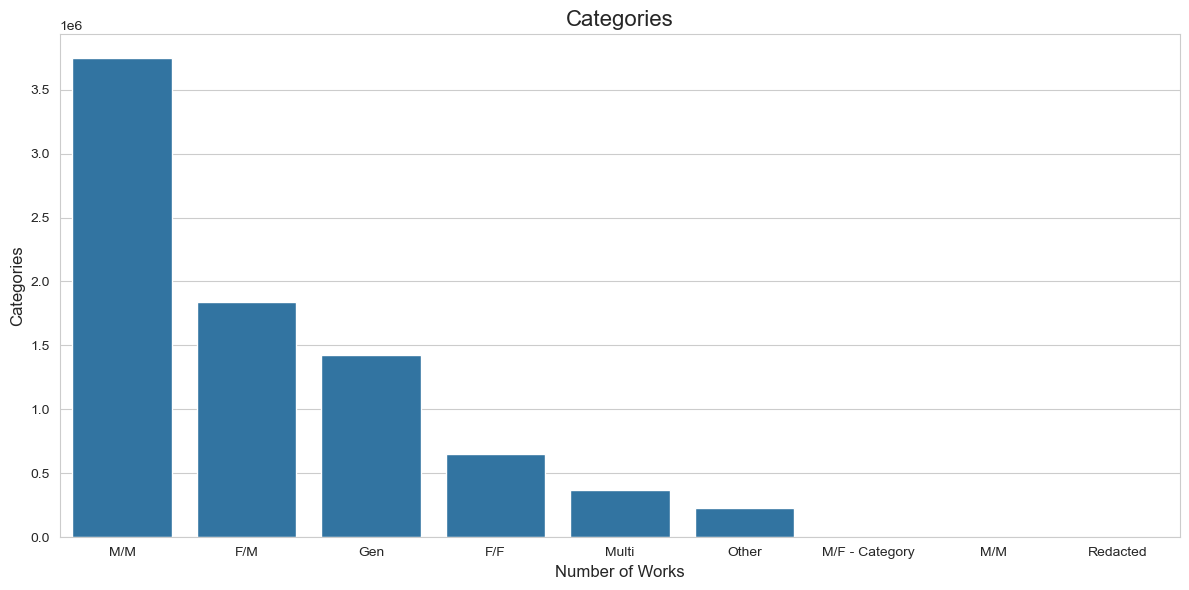

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=categories.sort_values(by="cached_count", ascending=False), x="name", y="cached_count")
# Customize the plot
plt.title('Categories', fontsize=16)
plt.xlabel('Number of Works', fontsize=12)
plt.ylabel('Categories', fontsize=12)
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

Ratings

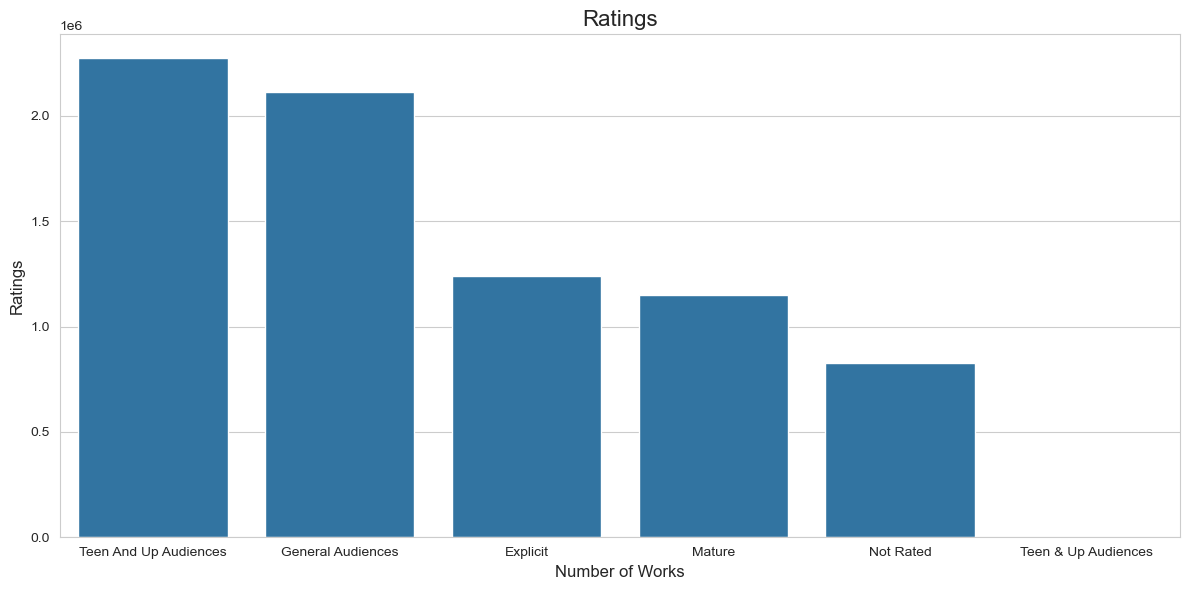

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(data=ratings.sort_values(by="cached_count", ascending=False), x="name", y="cached_count")
# Customize the plot
plt.title('Ratings', fontsize=16)
plt.xlabel('Number of Works', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

## NetworkX: Relationships/Characters

* drop redacted
* merge by merge ids to canoncial r/s
* split name col to create edge list, keep cached count as strength

In [17]:
# drop redacted and sort
relationships = relationships[relationships["name"] != "Redacted"]
relationships = relationships.sort_values(by="cached_count", ascending=False)
relationships

,id,type,name,canonical,cached_count,merger_id
173025,264659,Relationship,Derek Hale/Stiles Stilinski,True,122223,NaN
4700,5672,Relationship,Castiel/Dean Winchester,True,111991,NaN
8900,11006,Relationship,Sherlock Holmes/John Watson,True,87435,NaN
76021,110293,Relationship,"James ""Bucky"" Barnes/Steve Rogers",True,77276,NaN
85,99,Relationship,Draco Malfoy/Harry Potter,True,74244,NaN
...,...,...,...,...,...,...
9053597,34765316,Relationship,Helga Jace & Lynn Stewart,True,0,NaN
3202205,10744831,Relationship,Eugene Porter/Original Character(s),True,0,NaN
3202337,10745374,Relationship,Hannah/Benny Lafitte,True,0,NaN
3202344,10745395,Relationship,Gabriel/Lucifer/Lucifer/Sam Winchester,True,0,NaN


try to merge over merger_id

In [18]:
# merge ids
to_merge = relationships[~relationships['merger_id'].isnull()]
merge_df = pd.DataFrame(to_merge.groupby("merger_id")["cached_count"].sum())
merge_df

,cached_count
merger_id,
35.0,12375
36.0,530
72.0,8
99.0,8504
103.0,3447
...,...
55380162.0,61
55380561.0,85
55380609.0,9


In [19]:
relationships_total = relationships.merge(merge_df, left_on="id", right_on="merger_id")
relationships_total["cached_count"] = relationships_total["cached_count_x"] + relationships_total["cached_count_y"]
relationships_total = relationships_total.drop(columns=["cached_count_x", "cached_count_y", "merger_id"])
relationships_total

,id,type,name,canonical,cached_count
0,264659,Relationship,Derek Hale/Stiles Stilinski,True,131663
1,5672,Relationship,Castiel/Dean Winchester,True,160291
2,11006,Relationship,Sherlock Holmes/John Watson,True,117792
3,110293,Relationship,"James ""Bucky"" Barnes/Steve Rogers",True,142966
4,99,Relationship,Draco Malfoy/Harry Potter,True,82748
...,...,...,...,...,...
24595,34861064,Relationship,Lin Chen/Xing Conglian,True,32
24596,34824902,Relationship,Nezha | Third Lotus Prince/Everyone,True,6
24597,34723418,Relationship,Reid Garwin/Original Female Character(s),True,9
24598,34774655,Relationship,Asmodeus (Shadowhunter Chronicles)/Reader,True,16


make edgelist - damn, need to deal with more than 2 partners

In [20]:
relationships_count = relationships_total[["name", "cached_count"]]
relationships_count['name_list'] = relationships_count['name'].apply(lambda x: x.split('/'))
relationships_count.head()

/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/1691647718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relationships_count['name_list'] = relationships_count['name'].apply(lambda x: x.split('/'))


,name,cached_count,name_list
0,Derek Hale/Stiles Stilinski,131663,"[Derek Hale, Stiles Stilinski]"
1,Castiel/Dean Winchester,160291,"[Castiel, Dean Winchester]"
2,Sherlock Holmes/John Watson,117792,"[Sherlock Holmes, John Watson]"
3,"James ""Bucky"" Barnes/Steve Rogers",142966,"[James ""Bucky"" Barnes, Steve Rogers]"
4,Draco Malfoy/Harry Potter,82748,"[Draco Malfoy, Harry Potter]"


In [21]:
def generate_pairings(row):
    names = row['name_list']
    count = row['cached_count']
    return pd.DataFrame(list(combinations(names, 2)), columns=['name1', 'name2']).assign(cached_count=count)

pairs_df = pd.concat(relationships_count.apply(generate_pairings, axis=1).tolist(), ignore_index=True)
pairs_df

,name1,name2,cached_count
0,Derek Hale,Stiles Stilinski,131663
1,Castiel,Dean Winchester,160291
2,Sherlock Holmes,John Watson,117792
3,"James ""Bucky"" Barnes",Steve Rogers,142966
4,Draco Malfoy,Harry Potter,82748
...,...,...,...
23679,Lin Chen,Xing Conglian,32
23680,Nezha | Third Lotus Prince,Everyone,6
23681,Reid Garwin,Original Female Character(s),9
23682,Asmodeus (Shadowhunter Chronicles),Reader,16


yay have edgelist! now for networkX

# Key Levers for NetworkX

==> filter out pairings below minimum number of fics

In [241]:
min_fics = 10000
print(len(pairs_df))
pairs_df_top = pairs_df[pairs_df["cached_count"] > min_fics]
print("Shortened: ", len(pairs_df_top))

# sns.displot(data=pairs_df, x="cached_count", binwidth=1)

23684
Shortened:  107


==> change partition_resolution for size of communities

In [242]:
partition_resolution = 0.5

### NetworkX implementation

In [243]:
G = nx.from_pandas_edgelist(pairs_df_top, source='name1', target='name2', edge_attr='cached_count')
G.number_of_nodes()
G.edges(data = True)

EdgeDataView([('Derek Hale', 'Stiles Stilinski', {'cached_count': 131663}), ('Stiles Stilinski', 'Peter Hale', {'cached_count': 26983}), ('Castiel', 'Dean Winchester', {'cached_count': 160291}), ('Dean Winchester', 'Sam Winchester', {'cached_count': 47552}), ('Dean Winchester', 'You', {'cached_count': 13624}), ('Sherlock Holmes', 'John Watson', {'cached_count': 117792}), ('Sherlock Holmes', 'Molly Hooper', {'cached_count': 13073}), ('James "Bucky" Barnes', 'Steve Rogers', {'cached_count': 142966}), ('James "Bucky" Barnes', 'Tony Stark', {'cached_count': 22570}), ('James "Bucky" Barnes', 'Reader', {'cached_count': 12830}), ('Steve Rogers', 'Tony Stark', {'cached_count': 99472}), ('Draco Malfoy', 'Harry Potter', {'cached_count': 82748}), ('Draco Malfoy', 'Hermione Granger', {'cached_count': 26290}), ('Harry Potter', 'Severus Snape', {'cached_count': 24791}), ('Harry Potter', 'Tom Riddle', {'cached_count': 21061}), ('Harry Potter', 'Ginny Weasley', {'cached_count': 12684}), ('Tony Stark',

/Users/rgs/Desktop/fandomstudies/.conda/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


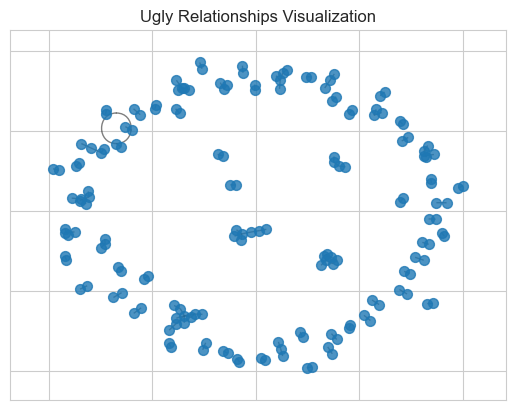

In [244]:
# Choose a layout
pos = nx.spring_layout(G)  # Spring layout

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.viridis, alpha=0.8)

# Draw the edges
edges = G.edges(data=True)
weights = [pairs_df_top['cached_count'] for u, v, data in edges]
nx.draw_networkx_edges(G, pos, edge_cmap=plt.cm.Blues, alpha=0.5)

# Draw the labels
# nx.draw_networkx_labels(G, pos, font_size=10)

# Display the graph
plt.title("Ugly Relationships Visualization")
plt.show()

Community split using louvain method

/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/4153505783.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(communities))


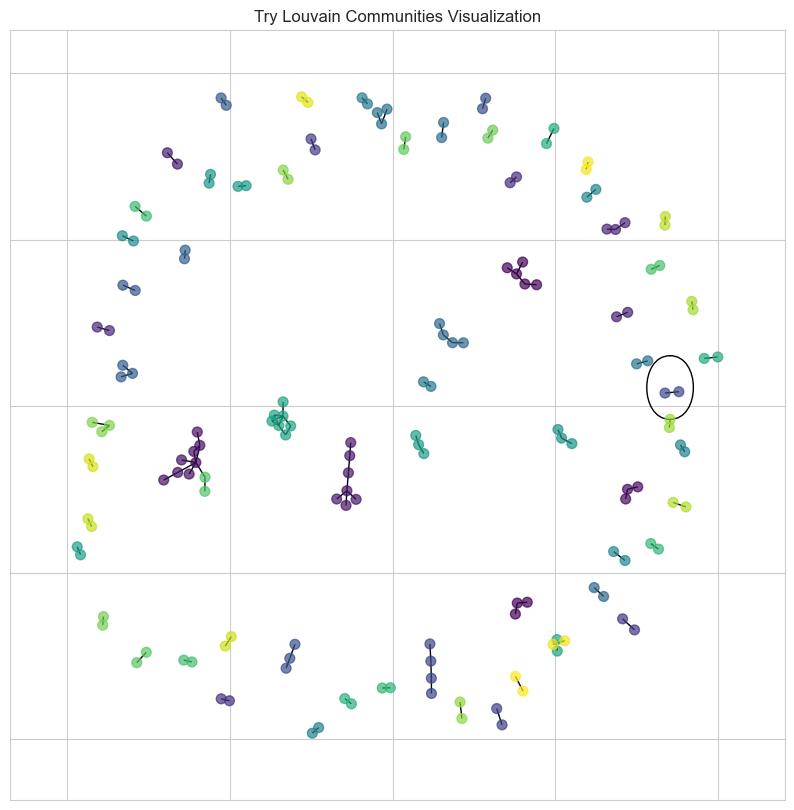

In [245]:
import community

# Compute the best partition using Louvain
partition = community.best_partition(G, resolution=partition_resolution, weight='cached_count')

# Draw the graph with community colors
pos = nx.spring_layout(G)

# Get a list of unique communities
communities = set(partition.values())
# Create a color map for the communities
cmap = plt.cm.get_cmap('viridis', len(communities))

# Map the partition to colors
node_colors = [cmap(partition[node]) for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color='black')
# nx.draw_networkx_labels(G, pos, font_size=12)
# plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(communities) - 1)), label='Community')

plt.title("Try Louvain Communities Visualization")
plt.show()

### Interactive!

In [246]:
output_notebook()


Loading BokehJS ...

In [247]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

In [248]:
edgelist = pairs_df_top
edgelist = edgelist.rename(columns={"cached_count": "weight"})

In [249]:
# convert names to indices so that bokeh can work?? not sure why this is needed but going with the ~flow~
# edgelist
unique_names = np.unique(edgelist[['name1', 'name2']].values)
name_index = {}
for v, k in enumerate(unique_names):
    name_index[k] = v
# name_index

# new edgelist replacing names with indices
index_edgelist = edgelist.replace(name_index)
# index_edgelist

G = nx.from_pandas_edgelist(index_edgelist, source='name1', target='name2', edge_attr='weight')
G.nodes(data=True)

/var/folders/lk/jwtj64_565zdwjrcvb73p4dc0000gn/T/ipykernel_26102/2216459369.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  index_edgelist = edgelist.replace(name_index)


NodeDataView({32: {}, 149: {}, 20: {}, 31: {}, 142: {}, 79: {}, 69: {}, 148: {}, 34: {}, 58: {}, 155: {}, 59: {}, 105: {}, 8: {}, 25: {}, 85: {}, 96: {}, 107: {}, 3: {}, 76: {}, 89: {}, 161: {}, 55: {}, 138: {}, 109: {}, 6: {}, 84: {}, 159: {}, 106: {}, 162: {}, 112: {}, 123: {}, 9: {}, 111: {}, 144: {}, 132: {}, 90: {}, 40: {}, 21: {}, 72: {}, 145: {}, 133: {}, 12: {}, 141: {}, 153: {}, 14: {}, 94: {}, 104: {}, 124: {}, 50: {}, 74: {}, 13: {}, 152: {}, 95: {}, 26: {}, 128: {}, 10: {}, 23: {}, 143: {}, 75: {}, 73: {}, 147: {}, 29: {}, 65: {}, 117: {}, 83: {}, 97: {}, 28: {}, 67: {}, 60: {}, 135: {}, 78: {}, 61: {}, 82: {}, 36: {}, 134: {}, 81: {}, 24: {}, 127: {}, 101: {}, 125: {}, 30: {}, 115: {}, 136: {}, 62: {}, 110: {}, 43: {}, 37: {}, 118: {}, 44: {}, 48: {}, 87: {}, 88: {}, 0: {}, 108: {}, 157: {}, 158: {}, 5: {}, 35: {}, 2: {}, 15: {}, 154: {}, 71: {}, 103: {}, 68: {}, 16: {}, 116: {}, 1: {}, 163: {}, 114: {}, 54: {}, 52: {}, 19: {}, 47: {}, 51: {}, 126: {}, 160: {}, 66: {}, 63:

In [250]:
index_name = {v: k for k, v in name_index.items()}
nx.set_node_attributes(G, name='name', values=index_name)

degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

# Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

Add modularity class and color as attributes to network graph

In [251]:
index_to_partition = {index: partition[name] for index, name in index_name.items()}

unique_partitions = list(set(partition.values()))

# get hex code
partition_to_color = {part_no: mcolors.to_hex(cmap(part_no)) for part_no in unique_partitions}
# partition_to_color = {part_no: (color) for part_no, color in partition_to_color.items()}
index_to_color = {index: partition_to_color[part_no] for index, part_no in index_to_partition.items()}
# index_to_color


In [252]:
# Add modularity class and color as attributes from the network above
nx.set_node_attributes(G, index_to_partition, 'partition')
nx.set_node_attributes(G, index_to_color, 'node_colors')

G.nodes(data=True)

NodeDataView({32: {'name': 'Derek Hale', 'degree': 1, 'adjusted_node_size': 6, 'partition': 0, 'node_colors': '#440154'}, 149: {'name': 'Stiles Stilinski', 'degree': 2, 'adjusted_node_size': 7, 'partition': 0, 'node_colors': '#440154'}, 20: {'name': 'Castiel', 'degree': 1, 'adjusted_node_size': 6, 'partition': 1, 'node_colors': '#450559'}, 31: {'name': 'Dean Winchester', 'degree': 3, 'adjusted_node_size': 8, 'partition': 1, 'node_colors': '#450559'}, 142: {'name': 'Sherlock Holmes', 'degree': 2, 'adjusted_node_size': 7, 'partition': 2, 'node_colors': '#460b5e'}, 79: {'name': 'John Watson', 'degree': 1, 'adjusted_node_size': 6, 'partition': 2, 'node_colors': '#460b5e'}, 69: {'name': 'James "Bucky" Barnes', 'degree': 3, 'adjusted_node_size': 8, 'partition': 3, 'node_colors': '#471164'}, 148: {'name': 'Steve Rogers', 'degree': 2, 'adjusted_node_size': 7, 'partition': 3, 'node_colors': '#471164'}, 34: {'name': 'Draco Malfoy', 'degree': 2, 'adjusted_node_size': 7, 'partition': 4, 'node_colo

### TIME TO GRAPH

chose fruchterman_reingold_layout over spring:

Computational Complexity
Both: O(n^2) in their basic implementations, making them computationally expensive for large graphs.

Aesthetic Quality
Fruchterman-Reingold: Generally produces visually pleasing layouts with good separation of nodes.
Spring Layout: Can also produce good layouts, but may require more tuning to avoid overlaps and ensure stability.

In [263]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 0.02 #'adjusted_node_size'
color_by_this_attribute = 'node_colors'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'AO3 Network: Relationships with more than ' + str(min_fics) + ' fics'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@name"),
        # ("Degree", "@degree"),
        #  ("Modularity Class", "@partition"),
        # ("Modularity Color", "$color[swatch]:node_colors")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
              width=800, height=800,
                x_range=Range1d(-1.5, 1.5), y_range=Range1d(-1.5, 1.5), title=title)

# pos = nx.spring_layout(G, k=0.5, iterations=1000)

pos = nx.fruchterman_reingold_layout(G, k=1, iterations=1000)

network_graph_communities = from_networkx(G, pos, scale=1, center=(0, 0))

network_graph_communities.node_renderer.glyph = Circle(radius=size_by_this_attribute, fill_color=color_by_this_attribute, fill_alpha=0.5)

network_graph_communities.edge_renderer.glyph = MultiLine(line_alpha=1, line_width=4, line_color="black")

plot.renderers.append(network_graph_communities)

show(plot)

# set output to static HTML file
output_file(filename="test.html", title="Test")

# save the results to a file
save(plot)

'/Users/rgs/Desktop/fandomstudies/test.html'